In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.model import SIREN
from src.laplacian import *
from scipy import sparse
from src.diff_operators import gradient, divergence

In [216]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    #hessians = np.zeros( (amount_samples, 2, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        #hessians[head:min(head + max_batch, amount_samples)] = jacobian( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians

model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

N = 255
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

fX, dfX, LfX = evaluate(  model, X, device=device )
LfX = np.clip( LfX, np.percentile(LfX, 1), np.percentile(LfX, 99))

In [217]:
LfX.min(), LfX.max()

(-1.1504732084274292, 19.725615615844738)

In [218]:
#u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[3] )
index = ( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[3]
mu = X[index, :]

normal = dfX[ index, :]
normal /= np.linalg.norm( normal )
tangent = np.random.uniform( 0 ,1, 2 )
tangent -= ( tangent @ normal ) * normal
tangent /= np.linalg.norm(tangent)

P = np.vstack( [normal, tangent] )
sigma1, sigma2 = 5e-2, 1e-2

A = P.T @ np.diag( [1/sigma1 ** 2, 1/sigma2 ** 2] ) @ P
x_p = X - np.tile( mu, (len(X),1))
u0 = np.exp( - (x_p.dot(A)*x_p).sum(axis=1))

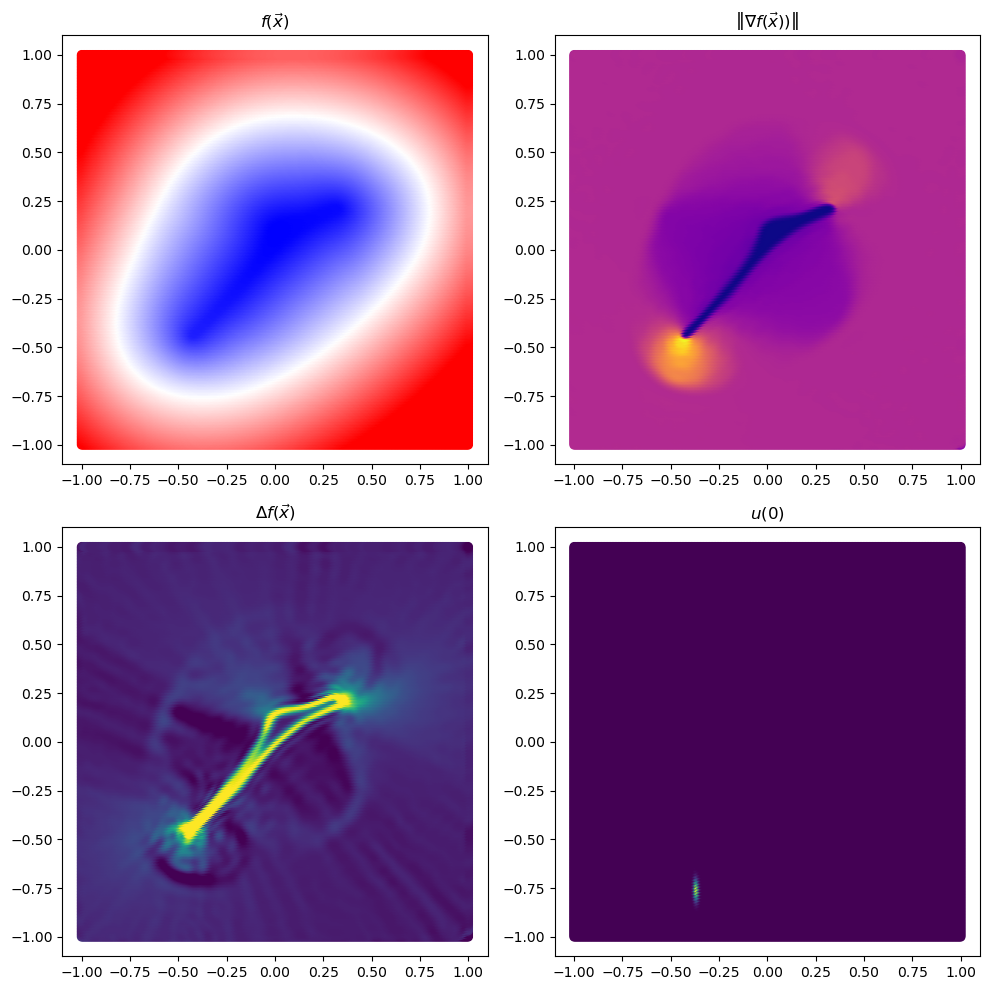

In [219]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )

axs[0][0].scatter(X[:,0], X[:,1], c=fX, cmap='bwr', vmin=-clip_val, vmax= clip_val)
axs[0][1].scatter(X[:,0], X[:,1], c=np.sum( dfX ** 2, axis=1), cmap='plasma')
axs[1][0].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[1][1].scatter(X[:,0], X[:,1], c=u0, cmap='viridis')

axs[0][0].set_title(r'$f(\vec{x})$')
axs[0][1].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1][0].set_title(r'$\Delta f(\vec{x})$')
axs[1][1].set_title(r'$u(0)$')

plt.tight_layout()
plt.show()

In [ ]:
mask = np.abs(fX).flatten() < 0.07

L_neumann, L_dirichlet = gridLaplacian( N, mask, boundary='neumann' ), gridLaplacian( N, mask, boundary='dirichlet' )
LB_neumann, LB_dirichlet = gridLaplaceBeltrami( N, dfX, LfX, mask, boundary='neumann' ), gridLaplaceBeltrami( N, dfX, LfX, mask, boundary='dirichlet' )

h = 2 / (N-1)
t = h ** 2 

I = sparse.csr_matrix( (N**2, N**2) )
I.setdiag( np.ones(N ** 2), k=0 )
ut_neumann_L = sparse.linalg.spsolve( (I - t * L_neumann ), u0.flatten() * mask.astype(np.int32) )
ut_dirichlet_L = sparse.linalg.spsolve( (I - t * L_dirichlet ), u0.flatten() * mask.astype(np.int32) )
ut_neumann = sparse.linalg.spsolve( (I - t * LB_neumann), u0.flatten() * mask.astype(np.int32) )
ut_dirichlet = sparse.linalg.spsolve( (I - t * LB_dirichlet), u0.flatten() * mask.astype(np.int32) )

/tmp/ipykernel_3522498/2505687257.py:6: RuntimeWarning: divide by zero encountered in log
  varadhan = np.sqrt( -4 * t * np.where( u == 0, np.zeros_like(u), np.log(u) ) )


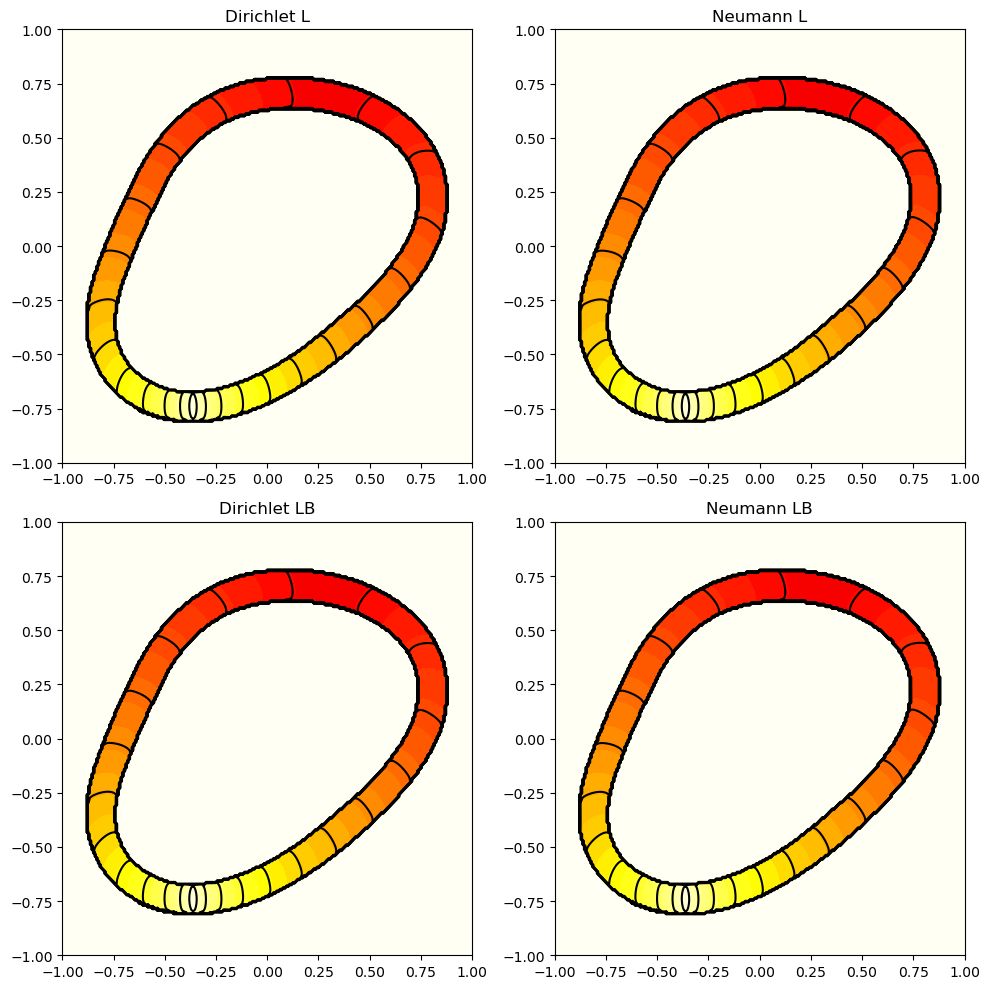

In [221]:
def contour( X, u, axis ):
    x_unique = np.unique(X[:, 0])
    y_unique = np.unique(X[:, 1])
    nx, ny = len(x_unique), len(y_unique)

    varadhan = np.sqrt( -4 * t * np.where( u == 0, np.zeros_like(u), np.log(u) ) )
    vmin, vmax = varadhan.min(), varadhan.max()
    u_grid = varadhan.reshape(ny, nx)

    num_levels = 20
    levels = np.linspace(vmin, vmax, num_levels)

    axis.contourf(x_unique, y_unique, u_grid, levels=50, cmap='hot_r')  
    axis.contour(x_unique, y_unique, u_grid, colors='black', levels=levels)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
contour( X, ut_dirichlet_L, axs[0][0])
contour( X, ut_neumann_L, axs[0][1])
contour( X, ut_dirichlet, axs[1][0])
contour( X, ut_neumann, axs[1][1])

axs[0][0].set_title('Dirichlet L')
axs[0][1].set_title('Neumann L')
axs[1][0].set_title('Dirichlet LB')
axs[1][1].set_title('Neumann LB')

plt.tight_layout()
plt.show()

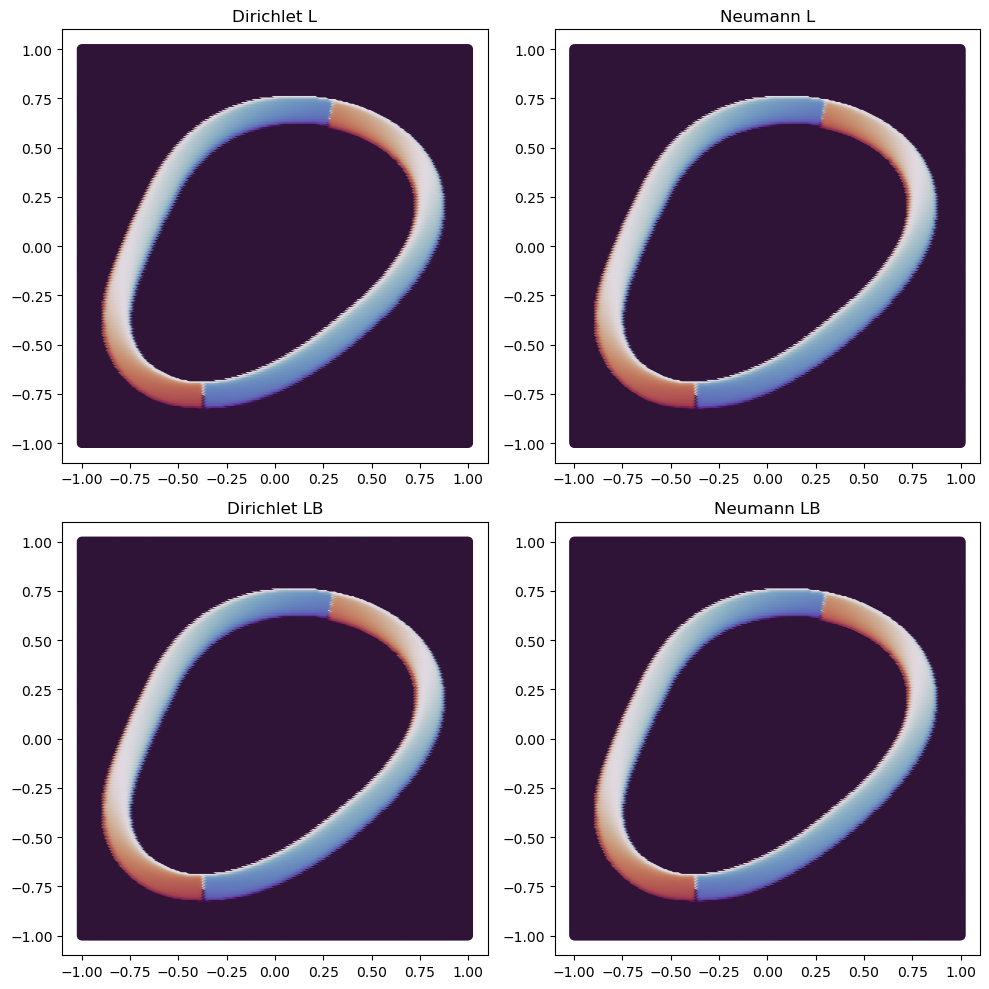

In [222]:
#Gx_dirichlet, Gy_dirichlet = gridIntrinsicGradient(N, dfX, np.abs(fX).flatten() < np.inf, boundary='dirichlet' )
#Gx_neumann, Gy_neumann = gridIntrinsicGradient(N, dfX, np.abs(fX).flatten() < np.inf, boundary='neumann' )
Gx_dirichlet, Gy_dirichlet = gridDxMasked(N, np.abs(fX).flatten() < np.inf ), gridDyMasked(N, np.abs(fX).flatten() < np.inf)
Gx_neumann, Gy_neumann = gridDxMasked(N, np.abs(fX).flatten() < np.inf, 'neumann'), gridDyMasked(N, np.abs(fX).flatten() < np.inf, 'neumann')

nx_neumann_L = Gx_neumann @ ut_neumann_L
nx_dirichlet_L = Gx_dirichlet @ ut_dirichlet_L
nx_neumann = Gx_neumann @ ut_neumann
nx_dirichlet = Gx_dirichlet @ ut_dirichlet

ny_neumann_L = Gy_neumann @ ut_neumann_L
ny_dirichlet_L = Gy_dirichlet @ ut_dirichlet_L
ny_neumann = Gy_neumann @ ut_neumann
ny_dirichlet = Gy_dirichlet @ ut_dirichlet

def normalmap( X, nx, ny, axis ):
    norm = np.sqrt( nx ** 2 + ny ** 2 )
    norm_nx = - ( nx ) / (norm + 1e-7)
    norm_ny = - ( ny ) / (norm + 1e-7)
    
    # Compute the angle of each vector
    angles = np.arctan2( -norm_nx, -norm_ny )
    # Normalize angles to range between 0 and 1 for colormap
    norm = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
    angles_normalized = norm(angles)
    axis.scatter( X[:,0], X[:,1], c=angles_normalized, cmap='twilight' )


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
normalmap( X, nx_dirichlet_L, ny_dirichlet_L, axs[0][0])
normalmap( X, nx_neumann_L, ny_neumann_L, axs[0][1])
normalmap( X, nx_dirichlet, ny_dirichlet, axs[1][0])
normalmap( X, nx_neumann, ny_neumann, axs[1][1])

axs[0][0].set_title('Dirichlet L')
axs[0][1].set_title('Neumann L')
axs[1][0].set_title('Dirichlet LB')
axs[1][1].set_title('Neumann LB')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3522498/2505687257.py:6: RuntimeWarning: divide by zero encountered in log
  varadhan = np.sqrt( -4 * t * np.where( u == 0, np.zeros_like(u), np.log(u) ) )


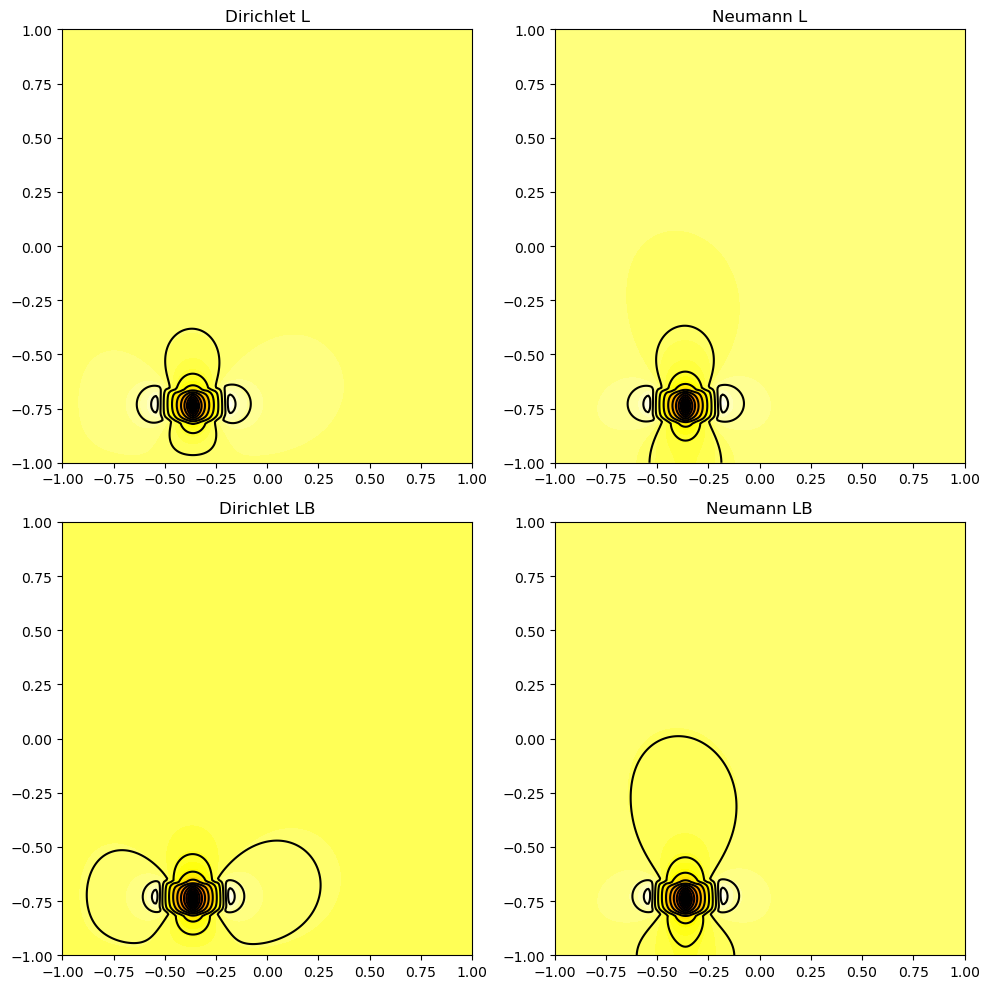

In [223]:
def heatgeodesic( X, nx, ny, axis, boundary='dirichlet' ):
    norm = np.sqrt( nx ** 2 + ny ** 2 )
    norm_nx = - ( nx ) / (norm + 1e-7)
    norm_ny = - ( ny ) / (norm + 1e-7)
    
    try:
        if boundary == 'dirichlet':
            #LB_dirichlet = gridLaplaceBeltrami(N, dfX, LfX, mask = np.abs(fX).flatten() < np.inf, boundary='dirichlet')
            L = gridLaplacian( N, np.abs(fX).flatten() < np.inf )
            phi = sparse.linalg.spsolve( L, Gx_dirichlet @ norm_nx + Gy_dirichlet @ norm_ny )
        elif boundary == 'neumann':
            #LB_neumann = gridLaplaceBeltrami(N, dfX, LfX, mask = np.abs(fX).flatten() < np.inf, boundary='neumann')
            L = gridLaplacian( N, np.abs(fX).flatten() < np.inf, 'neumann' )
            phi = sparse.linalg.spsolve( L, Gx_neumann @ norm_nx + Gy_neumann @ norm_ny )

        color = (phi - phi.min()) / (phi - phi.min()).max()
        contour( X, color, axis)
        #axis.scatter( X[:,0][mask], X[:,1][mask], c=color, marker='.', cmap='hot_r' )
    except Exception as e:
        print(e)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
heatgeodesic( X, nx_dirichlet_L, ny_dirichlet_L, axs[0][0])
heatgeodesic( X, nx_neumann_L, ny_neumann_L, axs[0][1], 'neumann')
heatgeodesic( X, nx_dirichlet, ny_dirichlet, axs[1][0])
heatgeodesic( X, nx_neumann, ny_neumann, axs[1][1], 'neumann')

axs[0][0].set_title('Dirichlet L')
axs[0][1].set_title('Neumann L')
axs[1][0].set_title('Dirichlet LB')
axs[1][1].set_title('Neumann LB')

plt.tight_layout()
plt.show()